In [4]:
import numpy as np
from qcg.generators import gen_supremacy, gen_hwea
from qiskit.transpiler.passes import NoiseAdaptiveLayout
from qiskit.converters import circuit_to_dag
from qiskit.compiler import transpile
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt

def cross_entropy(target,obs):
    assert len(target)==len(obs)
    alpha = 1e-14
    if 0 in obs:
        obs = [(x+alpha)/(1+alpha*len(obs)) for x in obs]
    assert abs(sum(obs)-1)<1e-5
    h = 0
    for p,q in zip(target,obs):
        if p==0:
            h += 0
        else:
            assert q>=0
            h += -p*np.log(q)
    return h

provider = IBMQ.load_account()
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates
num_shots = 1024

circ = gen_supremacy(2,3,5)
dag = circuit_to_dag(circ)
noise_mapper = NoiseAdaptiveLayout(properties)
noise_mapper.run(dag)
initial_layout = noise_mapper.property_set['layout']
new_circuit = transpile(circ, backend=device, basis_gates=basis_gates,coupling_map=coupling_map,backend_properties=properties,initial_layout=initial_layout)

print(circ)
print(initial_layout)
print(new_circuit)

/Users/weit/Documents/circuit_cutting/venv/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:178: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '
         ┌───┐     ┌────────────┐┌───┐                    ┌────────────┐┌───┐
q1_0: |0>┤ H ├──■──┤ Rx(1.5708) ├┤ T ├─■──────────────────┤ Rx(1.5708) ├┤ H ├
         ├───┤  │  ├────────────┤└───┘ │    ┌────────────┐└───┬───┬────┘├───┤
q1_1: |0>┤ H ├──■──┤ Rx(1.5708) ├──■───┼────┤ Ry(1.5708) ├────┤ T ├─────┤ H ├
         ├───┤┌───┐└────────────┘  │   │    └────────────┘┌───┴───┴────┐├───┤
q1_2: |0>┤ H ├┤ T ├────────────────■───┼──■───────────────┤ Rx(1.5708) ├┤ H ├
         ├───┤├───┤                    │  │               └────────────┘├───┤
q1_3: |0>┤ H ├┤ T ├────────────────────■──┼─────────────────────■───────┤ H ├
         ├───┤├───┤                       │                     │       ├───┤
q1_4: |0>┤ H ├┤ T ├───

In [5]:
# Ground truth
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend=backend)
result = job.result()
outputstate = result.get_statevector(circ)
ground_truth = [np.power(np.absolute(x),2) for x in outputstate]
print(sum(ground_truth),len(ground_truth))

0.9999999999999992 64


1.0 64


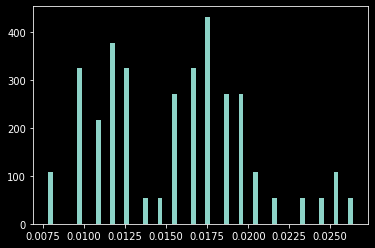

1.0

In [13]:
# No noise adaptive
c = ClassicalRegister(len(circ.qubits), 'c')
meas = QuantumCircuit(circ.qregs[0], c)
meas.barrier(circ.qubits)
meas.measure(circ.qubits,c)
qc = circ+meas
backend = Aer.get_backend('qasm_simulator')
result = execute(experiments=qc,
backend=backend,
noise_model=noise_model,
coupling_map=coupling_map,
basis_gates=basis_gates,
shots=num_shots,
initial_layout=None).result()
counts = result.get_counts(qc)
prob = [counts[i]/num_shots for i in counts]
print(sum(prob),len(prob))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(prob, len(prob), density=True)
fig.canvas.draw()
plt.show()
np.sum(n * np.diff(bins))

Layout({
11: (QuantumRegister(6, 'q0'), 0),
3: (QuantumRegister(6, 'q0'), 1),
2: (QuantumRegister(6, 'q0'), 2),
10: (QuantumRegister(6, 'q0'), 3),
9: (QuantumRegister(6, 'q0'), 4),
1: (QuantumRegister(6, 'q0'), 5),
0: (QuantumRegister(8, 'ancilla'), 0),
4: (QuantumRegister(8, 'ancilla'), 1),
5: (QuantumRegister(8, 'ancilla'), 2),
6: (QuantumRegister(8, 'ancilla'), 3),
7: (QuantumRegister(8, 'ancilla'), 4),
8: (QuantumRegister(8, 'ancilla'), 5),
12: (QuantumRegister(8, 'ancilla'), 6),
13: (QuantumRegister(8, 'ancilla'), 7)
})
63
1.0


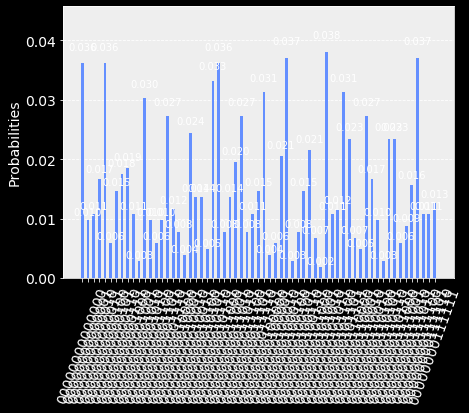

In [4]:
# Noise adaptive
c = ClassicalRegister(len(new_circuit.qubits), 'c')
meas = QuantumCircuit(new_circuit.qregs[0], c)
meas.barrier(new_circuit.qubits)
meas.measure(new_circuit.qubits[11],c[0])
meas.measure(new_circuit.qubits[3],c[1])
meas.measure(new_circuit.qubits[2],c[2])
meas.measure(new_circuit.qubits[10],c[3])
meas.measure(new_circuit.qubits[9],c[4])
meas.measure(new_circuit.qubits[1],c[5])
na_qc = new_circuit+meas
backend = Aer.get_backend('qasm_simulator')
na_result = execute(experiments=na_qc,
backend=backend,
noise_model=noise_model,
coupling_map=coupling_map,
basis_gates=basis_gates,
shots=num_shots,
initial_layout=None).result()
na_counts = na_result.get_counts(na_qc)
print(initial_layout)
# print(na_qc)
print(len(na_counts))
na_prob = [na_counts[i]/num_shots for i in na_counts]
print(sum(na_prob))
plot_histogram(na_counts)

In [5]:
print(cross_entropy(ground_truth,prob))
print(cross_entropy(ground_truth,na_prob))

4.310973452409231
4.780137658676729
